In [2]:
library(dplyr)
library(ggplot2)
library(ggmap)
library(data.table)
library(maptools)
library(rgdal)
options(jupyter.plot_mimetypes = 'image/png')

## Census tract data

To map data onto map at the census tract level, need to get California shapefile from census.gov. I chose cartographic boundary shapefiles for small scale mapping projects, at the 500k scale. The function readOGR() from the package rgdal can read shapefile into SpatialPolygonsDataFrame. GEOID has the unique ID for each county and will be used to join the ACS census data.

In [3]:
ca_shp = readOGR(dsn="./cb_2014_06_tract_500k", layer ="cb_2014_06_tract_500k")

OGR data source with driver: ESRI Shapefile 
Source: "./cb_2014_06_tract_500k", layer: "cb_2014_06_tract_500k"
with 8043 features
It has 9 fields


Warning message:
In readOGR(dsn = "./cb_2014_06_tract_500k", layer = "cb_2014_06_tract_500k"): Z-dimension discarded

## Insurace coverage data from ACS(American community survey)

Health insurance coverage data is from ACS 'ACS_14_5yr_S2701', 5-year estimate 2010-2014 for all census tracts in California. The column 'HC03_EST_VC01' is percent uninsured. GEO.id2 is the unique ID for each census tract and will be used to join census tract data.

In [4]:
ca_data = read.csv('ACS_14_5YR_S2701/ACS_14_5YR_S2701_with_ann.csv')

In [5]:
head(ca_data)

,GEO.id,GEO.id2,GEO.display.label,HC01_EST_VC01,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,ellip.h,HC01_EST_VC95,HC01_MOE_VC95,HC02_EST_VC95,HC02_MOE_VC95,HC03_EST_VC95,HC03_MOE_VC95,HC04_EST_VC95,HC04_MOE_VC95,HC05_EST_VC95,HC05_MOE_VC95
1,Id,Id2,Geography,Total; Estimate; Total civilian noninstitutionalized population,Total; Margin of Error; Total civilian noninstitutionalized population,Number Uninsured; Estimate; Total civilian noninstitutionalized population,Number Uninsured; Margin of Error; Total civilian noninstitutionalized population,Percent Uninsured; Estimate; Total civilian noninstitutionalized population,Percent Uninsured; Margin of Error; Total civilian noninstitutionalized population,Number Insured by Coverage Type; Estimate; Total civilian noninstitutionalized population,⋯,Total; Estimate; PERCENT IMPUTED - Health insurance coverage - Public coverage - VA Health Care,Total; Margin of Error; PERCENT IMPUTED - Health insurance coverage - Public coverage - VA Health Care,Number Uninsured; Estimate; PERCENT IMPUTED - Health insurance coverage - Public coverage - VA Health Care,Number Uninsured; Margin of Error; PERCENT IMPUTED - Health insurance coverage - Public coverage - VA Health Care,Percent Uninsured; Estimate; PERCENT IMPUTED - Health insurance coverage - Public coverage - VA Health Care,Percent Uninsured; Margin of Error; PERCENT IMPUTED - Health insurance coverage - Public coverage - VA Health Care,Number Insured by Coverage Type; Estimate; PERCENT IMPUTED - Health insurance coverage - Public coverage - VA Health Care,Number Insured by Coverage Type; Margin of Error; PERCENT IMPUTED - Health insurance coverage - Public coverage - VA Health Care,Percent Insured by Coverage Type; Estimate; PERCENT IMPUTED - Health insurance coverage - Public coverage - VA Health Care,Percent Insured by Coverage Type; Margin of Error; PERCENT IMPUTED - Health insurance coverage - Public coverage - VA Health Care
2,1400000US06001400100,06001400100,"Census Tract 4001, Alameda County, California",3385,545,114,63,3.4,1.9,3271,⋯,14.4,(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,1400000US06001400200,06001400200,"Census Tract 4002, Alameda County, California",1939,147,105,45,5.4,2.2,1834,⋯,8.0,(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,1400000US06001400300,06001400300,"Census Tract 4003, Alameda County, California",5428,466,404,203,7.4,3.8,5024,⋯,8.5,(X),(X),(X),(X),(X),(X),(X),(X),(X)
5,1400000US06001400400,06001400400,"Census Tract 4004, Alameda County, California",4274,326,292,100,6.8,2.3,3982,⋯,8.5,(X),(X),(X),(X),(X),(X),(X),(X),(X)
6,1400000US06001400500,06001400500,"Census Tract 4005, Alameda County, California",3516,282,555,251,15.8,6.6,2961,⋯,9.2,(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [6]:
ca_data = select(ca_data, GEO.id2, GEO.display.label, HC03_EST_VC01) %>% slice(-1) 
head(ca_data)

,GEO.id2,GEO.display.label,HC03_EST_VC01
1,06001400100,"Census Tract 4001, Alameda County, California",3.4
2,06001400200,"Census Tract 4002, Alameda County, California",5.4
3,06001400300,"Census Tract 4003, Alameda County, California",7.4
4,06001400400,"Census Tract 4004, Alameda County, California",6.8
5,06001400500,"Census Tract 4005, Alameda County, California",15.8
6,06001400600,"Census Tract 4006, Alameda County, California",22.1


In [7]:
str(ca_data)

'data.frame':	8057 obs. of  3 variables:
 $ GEO.id2          : Factor w/ 8058 levels "06001400100",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ GEO.display.label: Factor w/ 8058 levels "Census Tract 1, Colusa County, California",..: 3838 3839 3844 3847 3851 3853 3857 3858 3860 3867 ...
 $ HC03_EST_VC01    : Factor w/ 477 levels "-","0.0","0.1",..: 234 411 451 441 78 151 110 103 414 26 ...


In [8]:
#convert data types
ca_data$GEO.id2 = as.character(ca_data$GEO.id2)
ca_data$GEO.display.label = as.character(ca_data$GEO.display.label)
ca_data$percent = as.numeric(as.character(ca_data$HC03_EST_VC01))
str(ca_data)

Warning message:
In eval(expr, envir, enclos): NAs introduced by coercion

'data.frame':	8057 obs. of  4 variables:
 $ GEO.id2          : chr  "06001400100" "06001400200" "06001400300" "06001400400" ...
 $ GEO.display.label: chr  "Census Tract 4001, Alameda County, California" "Census Tract 4002, Alameda County, California" "Census Tract 4003, Alameda County, California" "Census Tract 4004, Alameda County, California" ...
 $ HC03_EST_VC01    : Factor w/ 477 levels "-","0.0","0.1",..: 234 411 451 441 78 151 110 103 414 26 ...
 $ percent          : num  3.4 5.4 7.4 6.8 15.8 22.1 19 18.3 5.7 10.6 ...


In [9]:
summary(ca_data$percent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    9.10   15.20   16.68   22.85   65.50      62 

## Merge census tract data with ACS insurance coverage data

To use census tract data, need to convert the SpatialPolygonsDataFrame back into data frame with fortify(). Join census tract data with insurace coverage data based on id(unique id for each census tract). Select three counties in the bay area to map, San Francisco, Alameda, and San Mateo.

In [10]:
ca_tract<-fortify(ca_shp,region = "GEOID") 
str(ca_tract)

'data.frame':	330321 obs. of  7 variables:
 $ long : num  -122 -122 -122 -122 -122 ...
 $ lat  : num  37.9 37.9 37.9 37.9 37.9 ...
 $ order: int  1 2 3 4 5 6 7 8 9 10 ...
 $ hole : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ piece: Factor w/ 6 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ id   : chr  "06001400100" "06001400100" "06001400100" "06001400100" ...
 $ group: Factor w/ 8112 levels "06001400100.1",..: 1 1 1 1 1 1 1 1 1 1 ...


In [11]:
ca_data$id = ca_data$GEO.id2
ca_tract2 = left_join(ca_tract,ca_data, by=c('id'))
dim(ca_tract2)

[1] 330321     11

In [12]:
ca_tract_sf = ca_tract2[grep('San Francisco',ca_tract2$GEO.display.label),]
dim(ca_tract_sf)

[1] 2980   11

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Francisco&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Francisco&sensor=false


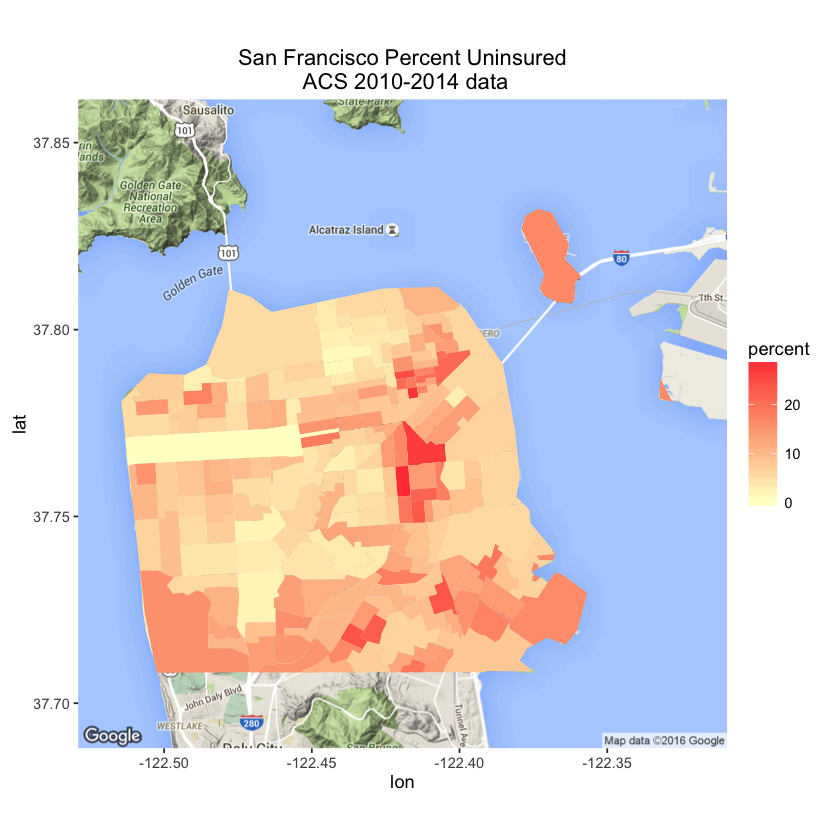

In [13]:
basemap <-get_map('San Francisco', zoom=12) 
ggmap(basemap) +
geom_polygon(data = ca_tract_sf , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('San Francisco Percent Uninsured\n ACS 2010-2014 data')

In [15]:
ca_tract_alameda = ca_tract2[grep('Alameda',ca_tract2$GEO.display.label),]
dim(ca_tract_alameda)

[1] 8398   11

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Hayward&zoom=10&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Hayward&sensor=false


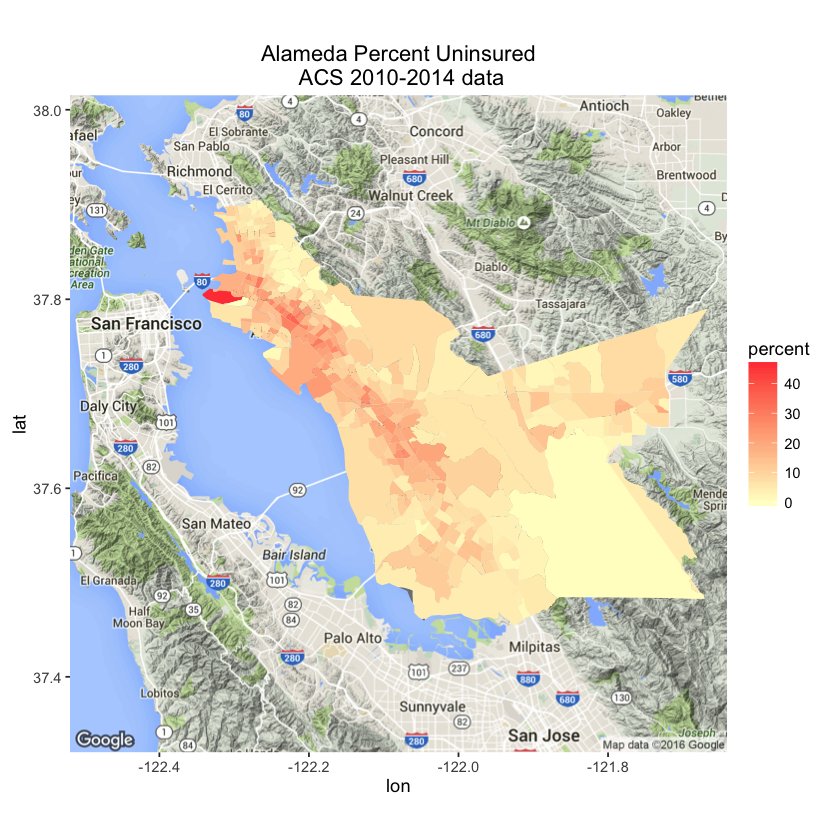

In [16]:
basemap <-get_map('Hayward', zoom=10) 
ggmap(basemap) +
geom_polygon(data = ca_tract_alameda , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('Alameda Percent Uninsured\n ACS 2010-2014 data')

In [17]:
ca_tract_sanmateo = ca_tract2[grep('San Mateo',ca_tract2$GEO.display.label),]
dim(ca_tract_sanmateo)

[1] 5235   11

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Mateo&zoom=10&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Mateo&sensor=false


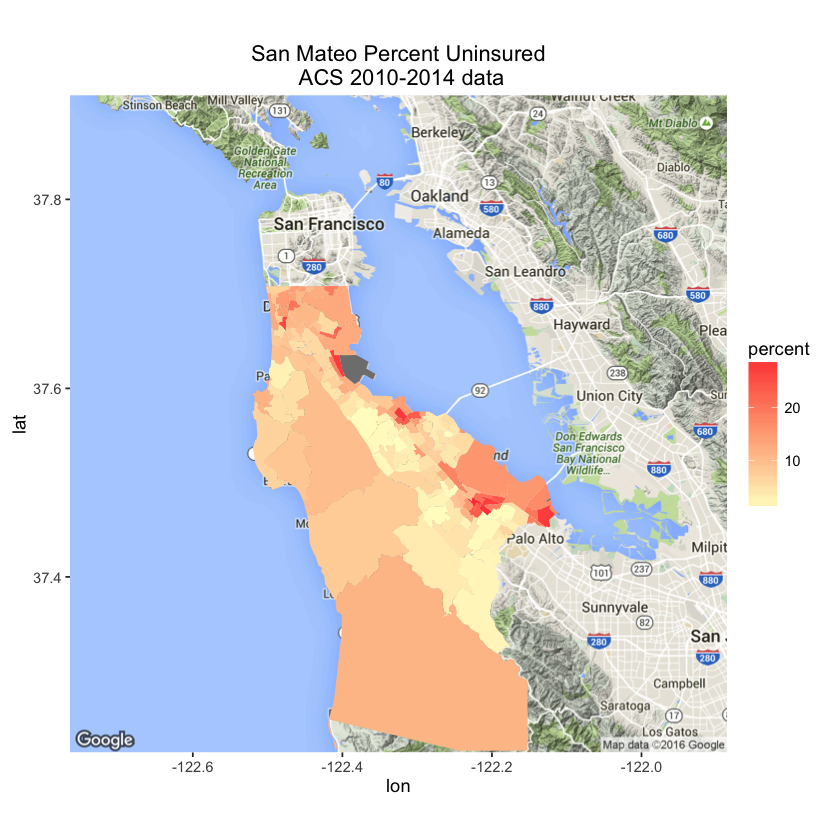

In [18]:
basemap <-get_map('San Mateo', zoom=10) 
ggmap(basemap) +
geom_polygon(data = ca_tract_sanmateo , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('San Mateo Percent Uninsured\n ACS 2010-2014 data')